# Deep Learning
## Blink detection

### 1. PRIMERA APROXIMACIÓN

CNN desde cero

### 1. Importar librerías
Lo primero que vamos a hacer es cargar las librería necesarias: TensorFlow y Keras (The Python Deep Learning library).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate, BatchNormalization, ReLU

from google.colab import drive
from sklearn.model_selection import train_test_split

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10854201638880839047
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12999016525644660988
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
# Generador custom que devuelve las dos imagenes de ojos y el label del parpadeo
def generator(dataframe, datagen):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                   directory = imgs_path,
                                                   target_size =(img_width, img_height),
                                                   x_col=left_eye_col,
                                                   y_col=y_col,
                                                   class_mode="binary",
                                                   seed=seed,
                                                   batch_size=batch_size)
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                    directory = imgs_path,
                                                    target_size =(img_width, img_height),
                                                    x_col=right_eye_col,
                                                    y_col=y_col,
                                                    class_mode="binary",
                                                    seed=seed,
                                                    batch_size=batch_size)
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label

In [5]:
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/RT-BENE.zip' >> /dev/null

data_path = 'RT-BENE/'
imgs_path = data_path + 'images/'
labels_path = data_path + 'blinks.csv'

seed = 0

# Actualizamos los indices de cada particion
train_data = pd.read_csv(labels_path, dtype=str) # Reading as string so the generator does not complain about the label (numeric being considered as an index)
no_aug_datagen = ImageDataGenerator(rescale=1./255)
aug_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40)

Mounted at /content/gdrive


In [6]:
print(train_data['blink'].value_counts())

0    102793
1      4557
Name: blink, dtype: int64


In [7]:
blink = train_data.loc[train_data['blink']=='1'].reset_index()
no_blink = train_data.loc[train_data['blink']=='0'].reset_index()

In [8]:
print(blink.shape[0])

4557


In [9]:
no_blink

,index,blink_id,left_eye,right_eye,video,blink
0,0,0,0_left_000001_rgb.png,0_right_000001_rgb.png,0,0
1,1,1,0_left_000002_rgb.png,0_right_000002_rgb.png,0,0
2,2,2,0_left_000003_rgb.png,0_right_000003_rgb.png,0,0
3,3,3,0_left_000004_rgb.png,0_right_000004_rgb.png,0,0
4,4,4,0_left_000005_rgb.png,0_right_000005_rgb.png,0,0
...,...,...,...,...,...,...
102788,107345,107345,16_left_009059_rgb.png,16_right_009059_rgb.png,16,0
102789,107346,107346,16_left_009060_rgb.png,16_right_009060_rgb.png,16,0
102790,107347,107347,16_left_009061_rgb.png,16_right_009061_rgb.png,16,0
102791,107348,107348,16_left_009062_rgb.png,16_right_009062_rgb.png,16,0


In [10]:
print(no_blink.loc[:blink.shape[0]].shape)

(4558, 6)


In [11]:
frames = [blink,blink,blink,blink,no_blink.loc[:blink.shape[0]],no_blink.loc[:blink.shape[0]],no_blink.loc[:blink.shape[0]],no_blink.loc[:blink.shape[0]]]
train_data = pd.concat(frames)

In [12]:
train_data

,index,blink_id,left_eye,right_eye,video,blink
0,160,160,0_left_000161_rgb.png,0_right_000161_rgb.png,0,1
1,161,161,0_left_000162_rgb.png,0_right_000162_rgb.png,0,1
2,162,162,0_left_000163_rgb.png,0_right_000163_rgb.png,0,1
3,163,163,0_left_000164_rgb.png,0_right_000164_rgb.png,0,1
4,164,164,0_left_000165_rgb.png,0_right_000165_rgb.png,0,1
...,...,...,...,...,...,...
4553,5131,5131,0_left_007097_rgb.png,0_right_007097_rgb.png,0,0
4554,5132,5132,0_left_007098_rgb.png,0_right_007098_rgb.png,0,0
4555,5133,5133,0_left_007099_rgb.png,0_right_007099_rgb.png,0,0
4556,5134,5134,0_left_007100_rgb.png,0_right_007100_rgb.png,0,0


In [13]:
print(train_data['blink'].value_counts())

0    18232
1    18228
Name: blink, dtype: int64


In [14]:
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=seed)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed)

train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

batch_size = 256
img_width = 60
img_height = 36

train_generator = generator(train_data)
dev_generator = generator(dev_data)
test_generator = generator(test_data)

In [ ]:
'''
# use tensorboard 
%load_ext tensorboard

logdir = 'tflogs'
writer = tf.summary.create_file_writer(logdir)

%tensorboard --logdir tflogs
'''

"\n# use tensorboard \n%load_ext tensorboard\n\nlogdir = 'tflogs'\nwriter = tf.summary.create_file_writer(logdir)\n\n%tensorboard --logdir tflogs\n"

In [ ]:
!pip3 install --upgrade pip
!pip3 install tfa-nightly
import tensorflow_addons as tfa

def f1_score(y_true,y_pred):
  metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

  metric.update_state(y_true, y_pred)
  result = metric.result()

  return result.numpy()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(train_data['blink'])
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.01
Weight for class 1: 0.99


In [ ]:
input_shape = (60, 36, 3)
# Declaramos dos capas de Input
input_1 = Input(name='left_eye', shape=input_shape)
input_2 = Input(name='right_eye', shape=input_shape)

concat_layer= Concatenate(name='concat', axis=-2)([input_1, input_2])

conv_1_1 = Conv2D(32, 3, name='conv1_l', padding='same', input_shape=(img_width,img_height,3))(concat_layer)
bn_1_1 = BatchNormalization()(conv_1_1)
re_1_1 = ReLU()(bn_1_1)
dr_1_1 = Dropout(0.5)(re_1_1)
max_1_1 = MaxPooling2D(name='max1_l', pool_size=2, strides=2)(dr_1_1)
conv_2_1 = Conv2D(64, 3, name='conv2_l', padding='same')(max_1_1)
bn_2_1 = BatchNormalization()(conv_2_1)
re_2_1 = ReLU()(bn_2_1)
dr_2_1 = Dropout(0.5)(re_2_1)
max_2_1 = MaxPooling2D(name='max2_l', pool_size=2, strides=2)(dr_2_1)

flat_layer_1 = Flatten(name='flat_l')(max_2_1)

'''
conv_1_2 = Conv2D(64, 5, name='conv1_r', padding='same', activation='relu', input_shape=(img_width,img_height,3))(input_2)
dr_1_2 = Dropout(0.5)(conv_1_2)
max_1_2 = MaxPooling2D(name='max1_r', pool_size=2, strides=2)(dr_1_2)
conv_2_2 = Conv2D(64, 5, name='conv2_r', padding='same', activation='relu')(max_1_2)
dr_2_2 = Dropout(0.5)(conv_2_2)
max_2_2 = MaxPooling2D(name='max2_r', pool_size=2, strides=2)(dr_2_2)
flat_layer_2 = Flatten(name='flat_r')(max_2_2)

concat_layer= Concatenate(name='concat')([flat_layer_1, flat_layer_2])
'''
dense_1 = Dense(5000, name='dense_1', activation='softmax')(flat_layer_1)
dense_2 = Dense(500, name='dense_2', activation='softmax')(dense_1)
predictions = Dense(1, name='output', activation='softmax')(dense_2)

# Creamos el modelo final y lo compilamos
model = Model(inputs=[input_1, input_2], outputs=[predictions])
# Compilamos el modelo
model.compile(loss='binary_crossentropy',                # función de pérdida para problemas de clasificación multi-clase
              optimizer=optimizers.Adam(learning_rate=1e-3),  # optimizador Adam
              metrics=[tfa.metrics.F1Score(num_classes=1),'accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_eye (InputLayer)          [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 right_eye (InputLayer)         [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concat (Concatenate)           (None, 60, 72, 3)    0           ['left_eye[0][0]',               
                                                                  'right_eye[0][0]']              
                                                                                                  
 conv1_l (Conv2D)               (None, 60, 72, 32)   896         ['concat[0][0]']           

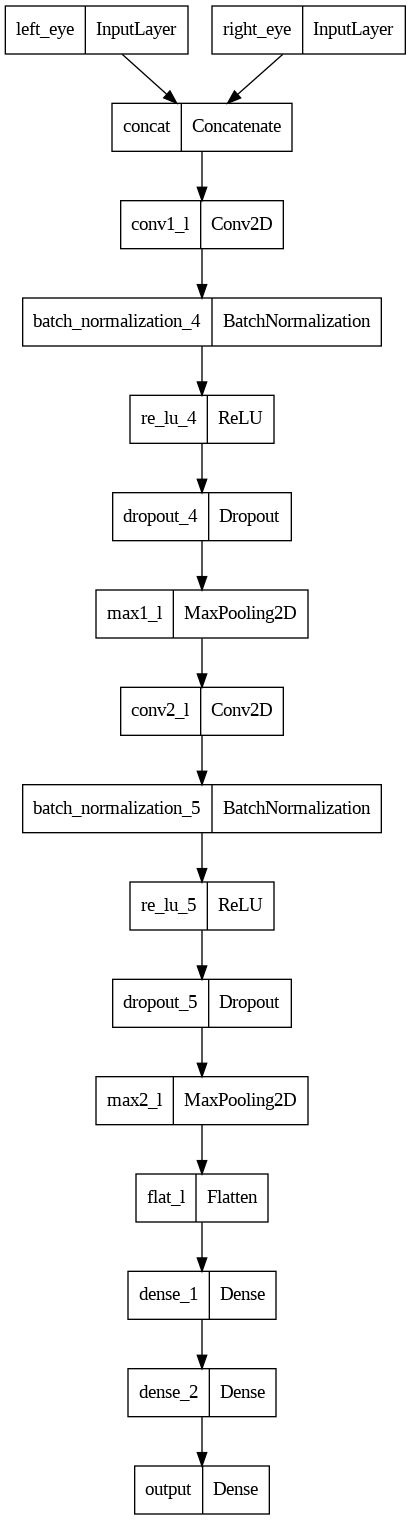

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

In [ ]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('categorical_crossentropy')
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train Loss')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])

Found 25522 validated image filenames belonging to 2 classes.
Found 25522 validated image filenames belonging to 2 classes.


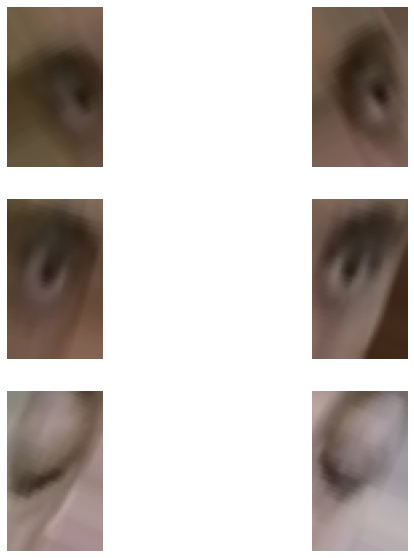

In [ ]:
aug_iter = generator(train_data)
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(10,10))

for i in range(3):
  eye = next(aug_iter)
  left_eye_image = eye[0][0][i]
  right_eye_image = eye[0][1][i]

  ax[i,0].imshow(right_eye_image)
  ax[i,1].imshow(left_eye_image)
  ax[i,0].axis('off')
  ax[i,1].axis('off')

In [ ]:
# Entrenamos el modelo con los datos preparados en el punto 2
#callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir)]
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size,
                    class_weight=class_weight)

Epoch 1/20
99/99 [==============================] - 87s 847ms/step - loss: 0.6912 - f1_score: 0.6686 - accuracy: 0.5022 - val_loss: 0.6922 - val_f1_score: 0.6581 - val_accuracy: 0.4904
Epoch 2/20
99/99 [==============================] - 73s 743ms/step - loss: 0.6769 - f1_score: 0.6695 - accuracy: 0.5032 - val_loss: 0.6824 - val_f1_score: 0.6609 - val_accuracy: 0.4935
Epoch 3/20
99/99 [==============================] - 73s 735ms/step - loss: 0.6410 - f1_score: 0.6687 - accuracy: 0.5023 - val_loss: 0.6418 - val_f1_score: 0.6651 - val_accuracy: 0.4983
Epoch 4/20
99/99 [==============================] - 72s 732ms/step - loss: 0.5904 - f1_score: 0.6679 - accuracy: 0.5014 - val_loss: 0.6182 - val_f1_score: 0.6551 - val_accuracy: 0.4871
Epoch 5/20
99/99 [==============================] - 73s 735ms/step - loss: 0.5318 - f1_score: 0.6709 - accuracy: 0.5048 - val_loss: 0.5193 - val_f1_score: 0.6684 - val_accuracy: 0.5019
Epoch 6/20
99/99 [==============================] - 74s 746ms/step - loss: 

In [ ]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss, test_f1 = model.evaluate(test_generator,
                                     batch_size=batch_size,
                                     steps=len(test_data)/batch_size,
                                     verbose=1)
print("test_loss: %.4f, test_f1: %.4f" % (test_loss, test_f1))

In [ ]:
y_pred = model.predict(test_generator,
                       batch_size=batch_size,
                       steps=len(test_data)/batch_size,
                       verbose=1)

In [ ]:
metric = tfa.metrics.F1Score(num_classes=1,average="micro")

In [ ]:
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()